<a href="https://colab.research.google.com/github/ciphenseadmin/partial-face-recognition/blob/master/VGGFace_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-f7c1mwk1
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-f7c1mwk1
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=ece26fcdbc96c888334316d186cb3a762808911f37185b06504c4f57299e5d27
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_btr0oo/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
!pip install keras_vggface

In [0]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint
#custom parameters
nb_class = 217

hidden_dim = 512

# vgg_model = VGGFace(include_top=False, input_shape=(128, 128, 3),pooling='avg')
vgg_model = VGGFace(include_top=False,pooling='avg')
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)
    

Using TensorFlow backend.


ModuleNotFoundError: ignored

In [0]:
layer_count = 0
for layer in custom_vgg_model.layers:
	layer_count = layer_count+1

for l in range(layer_count-5):
	custom_vgg_model.layers[l].trainable=False
    

In [0]:
custom_vgg_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
preprocess_input = utils.preprocess_input
datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [0]:
from keras.callbacks import Callback
image_size = 128
ACCURACY_THRESHOLD = 0.94
class myCallback(Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        # if(logs.get('acc') > ACCURACY_THRESHOLD):   
        # # print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
        self.model.stop_training = True

callbacks = myCallback()

train_generator = datagenerator.flow_from_directory(
        'train',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',)

validation_generator = datagenerator.flow_from_directory(
        'test',
        target_size=(image_size, image_size),
        class_mode='categorical')

hisory = custom_vgg_model.fit_generator(
        train_generator,
        validation_data=validation_generator,
        validation_steps=1,epochs=50,callbacks=[myCallback ])

Found 3264 images belonging to 217 classes.
Found 1539 images belonging to 217 classes.
Epoch 1/50
102/102 [==============================] - 11s 108ms/step - loss: 7.1864 - accuracy: 0.2754 - val_loss: 3.2985 - val_accuracy: 0.3750
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 2.2883 - accuracy: 0.5156 - val_loss: 2.6178 - val_accuracy: 0.3438
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 1.2504 - accuracy: 0.6939 - val_loss: 1.9622 - val_accuracy: 0.5312
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8627 - accuracy: 0.7926 - val_loss: 1.5690 - val_accuracy: 0.6875
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6035 - accuracy: 0.8474 - val_loss: 2.3076 - val_accuracy: 0.5000
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.4708 - accuracy: 0.8750 - val_loss: 2.2502 - val_accuracy: 0.6250
Epoch 7/50
102/102 [======================

In [0]:
# !cp -r '/content/drive/My Drive/SubsetLfwCropped_vartika/train' 'train' 
# !cp -r '/content/drive/My Drive/SubsetLfwCropped_vartika/test'  'test'

In [0]:
best_val_acc = max(hisory.history['val_accuracy'])
print(best_val_acc)

1.0


In [0]:
scores = custom_vgg_model.evaluate_generator(validation_generator)
scores

[4.505699634552002, 0.6881091594696045]

In [0]:
!pip install mtcnn
import mtcnn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os


def extract_face(filename='', required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    # print(image)
    face_array = np.asarray(image)
    plt.imshow(face_array)
    plt.show()
    return face_array
    

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
try:
    file_name ='test.jpg'
    filename = take_photo(file_name)
    print('Saved to {}'.format(filename))
    
# Show the image which was just taken.
    # display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

<IPython.core.display.Javascript object>

Saved to test.jpg


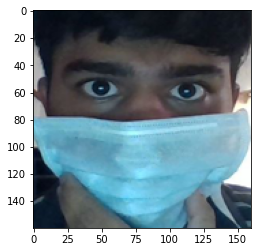

In [0]:
pixels = extract_face(os.path.join('test.jpg'))
plt.imsave('test_.jpg',pixels)

In [0]:
from keras.preprocessing import image
import numpy as np
test_path = input()
img = image.load_img(test_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=1) # or version=2
preds = custom_vgg_model.predict(x)
print(preds[0])

/content/test_1-with-mask.jpg
[1.0000000e+00 1.0362444e-29 0.0000000e+00]


In [0]:
/content/test_.jpg